# ARIMA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import os
import itertools
import warnings
%matplotlib inline

In [2]:
data_directory = r"C:\Users\sb013698\Desktop\github\Machine Learning in Finance\Datasets"

In [3]:
# Suppress specific warning related to frequency (no need to import ValueWarning explicitly)
warnings.filterwarnings("ignore", message=".*frequency.*")
warnings.filterwarnings("ignore", category=UserWarning)

### Parameters of ARIMA Models

- **AutoRegressive (AR) Order, p:** 
   - Represents the number of lag observations included in the model.
   - It models the relationship between an observation and several past observations (lags).
   - **Formula** for AR:
     $$
     y_t = \phi_1 y_{t-1} + \phi_2 y_{t-2} + \dots + \phi_p y_{t-p} + \epsilon_t
     $$
     where:
     - $y_t$ is the current value at time $t$,
     - ${\phi_1, \phi_2, ..., \phi_p}$ are the coefficients for the previous observations,
     - $\epsilon_t$ is the error term at time $t$.

---

2. **Differencing Order, d:**
   - Represents the number of differencing operations to make the time series stationary.
   - Differencing is applied to remove trends or seasonality in the series.
   - **Formula** for Differencing (first difference):
     $$
     \Delta y_t = y_t - y_{t-1}
     $$
     where:
     - $\Delta y_t$ is the differenced value at time $t$,
     - $y_t$ is the original value at time $t$.

---

3. **Moving Average (MA) Order, q:**
   - Represents the number of lagged forecast errors included in the model.
   - It models the relationship between the current value and previous forecast errors.
   - **Formula** for MA:
     $$
     y_t = \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \dots + \theta_q \epsilon_{t-q} + \epsilon_t
     $$
     where:
     - $y_t$ is the current value at time $t$,
     - $\epsilon_t$ is the error term at time $t$,
     - ${\theta_1, \theta_2, ..., \theta_q}$ are the coefficients for the forecast errors.

## Fitting ARIMA Models to Turkish Unemployment Rate Data
- We will focus on fitting ARIMA type model to Turkish monthly unemployment rate data. The data is obtained from Central Bank, and provided as "unemployment.xlsx".
- We will try to determine the optimal integration order for ARIMA: p, d, and q. 

In [4]:
data = pd.read_excel(os.path.join(data_directory, "unemployment.xlsx"))
print(data.shape)

(116, 2)


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Tarih           116 non-null    object 
 1   TP YISGUCU2 G8  116 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.9+ KB


In [6]:
data['Tarih'] = pd.to_datetime(data['Tarih'])  # Ensure the date column is datetime
data.set_index('Tarih', inplace=True)  # Set the date column as index
data.index = pd.to_datetime(data.index)  # Ensure it's a DatetimeIndex

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 116 entries, 2014-01-01 to 2023-08-01
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TP YISGUCU2 G8  116 non-null    float64
dtypes: float64(1)
memory usage: 1.8 KB


In [7]:
data.head(10)

,TP YISGUCU2 G8
Tarih,
2014-01-01,10.5
2014-02-01,10.5
2014-03-01,9.4
2014-04-01,8.8
2014-05-01,8.4
2014-06-01,9.0
2014-07-01,9.7
2014-08-01,10.1
2014-09-01,10.1


In [8]:
# Define target
target_column = "TP YISGUCU2 G8"
unemployment_rate = data[target_column]

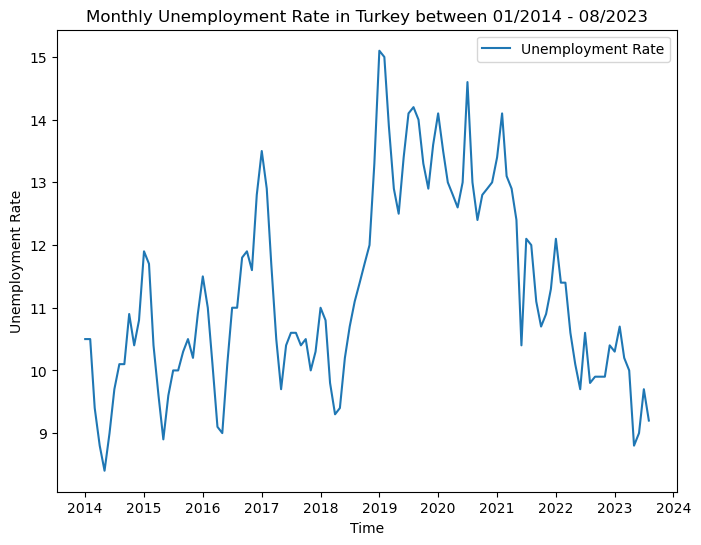

In [9]:
# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(unemployment_rate, label="Unemployment Rate")
plt.title("Monthly Unemployment Rate in Turkey between 01/2014 - 08/2023")
plt.xlabel("Time")
plt.ylabel("Unemployment Rate")
plt.legend()
plt.show()

In [10]:
# Function to check stationarity and apply differencing if needed
def check_stationarity_and_diff(series, max_diff=2, alpha=0.05):
    """
    This function checks if a time series is stationary using the Augmented Dickey-Fuller test.
    If the series is not stationary, it applies first and second differencing until it becomes stationary or reaches max_diff iterations.

    Parameters:
    - series: The time series data to check.
    - max_diff: Maximum number of differencings to apply. Default is 2 (first and second differencing).
    - alpha: The significance level for the ADF test. Default is 0.05.
    
    Returns:
    - A stationary series (after differencing, if necessary).
    - The number of differencings applied.
    - ADF p-values after each differencing.
    """
    
    def adf_test(series):
        result = adfuller(series)
        return result[1]  # p-value
    
    # Step 1: Check for stationarity on the original series
    adf_p_value = adf_test(series)
    print(f"ADF p-value for original series: {adf_p_value}")

    if adf_p_value < alpha:
        print("The series is stationary.")
        return series, 0, [adf_p_value]
    
    # Step 2: If the series is non-stationary, apply differencing
    diff_series = series.copy()
    adf_p_values = [adf_p_value]
    for i in range(1, max_diff + 1):
        diff_series = diff_series.diff().dropna()  # Apply differencing
        adf_p_value = adf_test(diff_series)  # Recheck stationarity after differencing
        adf_p_values.append(adf_p_value)
        print(f"ADF p-value for {i}-th differenced series: {adf_p_value}")
        
        if adf_p_value < alpha:
            print(f"The series is stationary after {i} differencings.")
            return diff_series, i, adf_p_values
    
    print(f"The series is still non-stationary after {max_diff} differencings.")
    return diff_series, max_diff, adf_p_values

# Call the function to check stationarity and apply differencing if needed
unemployment_rate = data[target_column]  # Replace with your actual data column
stationary_series, differencing_count, p_values = check_stationarity_and_diff(unemployment_rate)

ADF p-value for original series: 0.4029339295539812
ADF p-value for 1-th differenced series: 0.13536547968255624
ADF p-value for 2-th differenced series: 4.77170631299393e-15
The series is stationary after 2 differencings.


**Notes:**

- Stationarity refers to whether the statistical properties of a time series, such as the mean and variance, remain constant over time. This concept is essential in time series forecasting, especially when using models like ARIMA (AutoRegressive Integrated Moving Average).
- If your time series is non-stationary, it may show trends or patterns that change over time. This can affect how well an ARIMA model fits the data.
- Differencing (d) is often used to make the time series stationary by removing trends (e.g., by applying first differencing if the series has a linear trend).

In [11]:
# Define the range of p, d, q values
p = [0, 1, 2]
q = [0, 1, 2]
d = [2]  # Value that makes the data stationary based on previous analysis

# Generate all combinations of p, d, q
combinations = list(itertools.product(p, d, q))

# List to store the results
results_list = list()

# Fit different ARIMA models and collect results
for param in combinations:
    try:
        if param[1] == 0:  # If d=0, use the original data (no differencing)
            model = ARIMA(unemployment_rate, order=param)
        elif param[1] == 1:  # If d=1, use the first differenced data
            model = ARIMA(stationary_series, order=param)
        elif param[1] == 2:  # If d=2, use the second differenced data
            model = ARIMA(stationary_series.diff().dropna(), order=param)
        
        results = model.fit()
        results_list.append({
            'p': param[0],
            'd': param[1],
            'q': param[2],
            'AIC': results.aic,
            'BIC': results.bic,
            'Log-Likelihood': results.llf,
            'ADF P-Value': p_values[-1]  # Last p-value from differencing
        })
    except Exception as e:
        print(f"Error fitting model {param}: {e}")
        continue

# Convert results list to a DataFrame
results_df = pd.DataFrame(results_list)
results_df.sort_values(by="AIC", ascending=True)

,p,d,q,AIC,BIC,Log-Likelihood,ADF P-Value
8,2,2,2,367.326593,380.874244,-178.663296,4.771706e-15
5,1,2,2,389.835151,400.673272,-190.917576,4.771706e-15
2,0,2,2,420.545044,428.673635,-207.272522,4.771706e-15
7,2,2,1,431.245075,442.083196,-211.622538,4.771706e-15
4,1,2,1,474.111737,482.240327,-234.055868,4.771706e-15
6,2,2,0,515.437883,523.566473,-254.718941,4.771706e-15
1,0,2,1,531.845692,537.264752,-263.922846,4.771706e-15
3,1,2,0,576.548057,581.967118,-286.274029,4.771706e-15
0,0,2,0,657.423730,660.133260,-327.711865,4.771706e-15


In [12]:
# Select the best model based on the lowest AIC
best_model_row = results_df.loc[results_df['AIC'].idxmin()]
best_order = (int(best_model_row['p']), int(best_model_row['d']), int(best_model_row['q']))
print(f"Optimal ARIMA order (p, d, q): {best_order}")

Optimal ARIMA order (p, d, q): (2, 2, 2)


## Evaluation Metrics
#### AIC (Akaike Information Criterion):
AIC evaluates the quality of a statistical model by balancing goodness of fit and model complexity. It is defined as:

$$
\text{AIC} = 2k - 2\ln(L)
$$

Where $k$ is the number of model parameters and $L$ is the likelihood of the model.

#### BIC (Bayesian Information Criterion):
BIC is similar to AIC but applies a stricter penalty for model complexity, especially when the sample size is large. It is defined as:

$$
\text{BIC} = \ln(n)k - 2\ln(L)
$$

Where $n$ is the number of observations, $k$ is the number of model parameters, and $L$ is the likelihood of the model.

#### Why Use AIC and BIC?
- When no explicit training-test split exists, these metrics help compare models by penalizing complexity to avoid overfitting.
- **AIC** prioritizes fit and is often used in exploratory analysis.
- **BIC** is more conservative, favoring simpler models as sample size increases.
- Both are useful for model selection in time series and regression analysis when a holdout (test) set is unavailable.

# END